In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import os

### Import dataset and put into dataloader

In [2]:
# import CIFAR-10 dataset into trainset, testset
# load in to trainloader, testloader

# color dataset
transform_color = transforms.Compose([
        transforms.ToTensor(),
         transforms.Normalize((0.5), (0.5))
    ])

batchSize = 2

trainset_color = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_color)
trainloader_color = torch.utils.data.DataLoader(trainset_color, batch_size=batchSize,
                                          shuffle=True, num_workers=2)

testset_color = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_color)
testloader_color = torch.utils.data.DataLoader(testset_color, batch_size=batchSize,
                                         shuffle=False, num_workers=2)

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)

Files already downloaded and verified
Files already downloaded and verified
cuda:0


### Pre-processing: Convert all rgb images to gray images

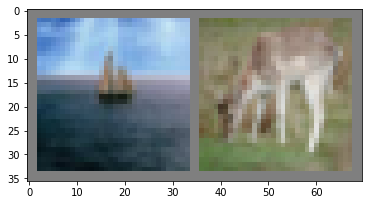

torch.Size([2, 3, 32, 32])


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.savefig('plot/result_sanity_'+str(batchSize)+'.png')
    plt.show()
    

# get some random training images
dataiter = iter(trainloader_color)
images_color, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images_color))

# show dataiter shape
print(images_color.shape)

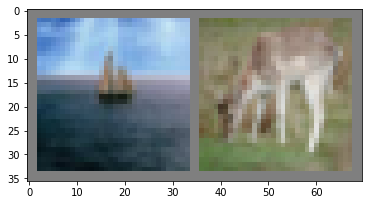

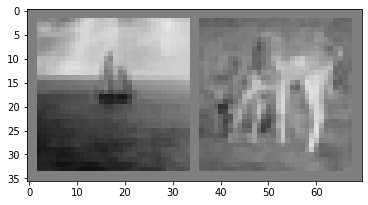

images_gray shape:  torch.Size([2, 1, 32, 32])


In [4]:
# function to convert a rgb_img to gray_img
def rgb2gray(img):
    rgb_img = img.transpose(1,2,0)
    gray_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2GRAY)
    return gray_img

# function to convert a batch of rgb images to gray images
def rgb2gray_batch(images):
    rgb_images = np.array(images)    
    
    gray_images = []
#     print("rgb_images.shape: ", rgb_images.shape[0])
    for i in range(rgb_images.shape[0]):
        img = rgb_images[i]
        gray_img = rgb2gray(img)
        gray_images.append(gray_img)
    
    gray_images = np.array(gray_images)
    gray_images = torch.from_numpy(gray_images)
    return gray_images
        
images_gray = rgb2gray_batch(images_color)

# show images
images_gray = images_gray.reshape(batchSize,1,32,32)

imshow(torchvision.utils.make_grid(images_color))
imshow(torchvision.utils.make_grid(images_gray))
print("images_gray shape: ", images_gray.shape)

### Define the MLP network

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class MLP_net(nn.Module):
    def __init__(self):
        # Input layer is 1024, since CIFAR-10 gray_image is 32x32
        # Output layer is 3072, since CIFAR-10 gray_image is 32x32x3
        super(MLP_net, self).__init__()
        
        self.layer1 = nn.Linear(1024,1024)
#         self.bn1 = nn.InstanceNorm1d(32)
        self.layer2 = nn.Linear(1024,3072)
        
    def forward(self, x):
        # convert tensor (4, 1, 32, 32) --> (4, 1*32*32)
        x = x.view(x.size(0), -1)
        
        x = self.layer1(x)
#         x = self.bn1(x)
        x = self.layer2(x)
        
        return x

mlp_net = MLP_net().to(device)

print("is cude: ", next(mlp_net.parameters()).is_cuda)

model_path = "./saved_model/mlp_"+str(batchSize)+ ".pt"
if os.path.exists(model_path):
    print("Continue training from the saved model")
    mlp_net.load_state_dict(torch.load(model_path))

is cude:  True
Continue training from the saved model


### Define the loss function and optimizer

In [6]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.SGD(mlp_net.parameters(), lr=0.001, momentum=0.9)

### Tensorboard to save all training output logs

In [7]:
from torch.utils.tensorboard import SummaryWriter

# Writer will output to ./runs/ directory by default
writer = SummaryWriter("./runs/mlp_"+str(batchSize)+"/")

### Train the network

cpu


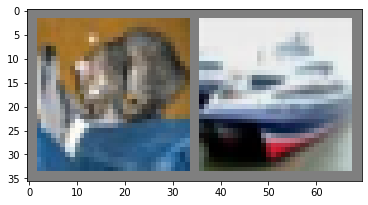

Finished Training


In [8]:
dataiter = iter(testloader_color)
image_cpu_color, labels_color = dataiter.next()
print(image_cpu_color.device)

# show images
img = image_cpu_color
img = img.reshape(batchSize,3,32,32)
imshow(torchvision.utils.make_grid(img.detach()))

for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    num_training = 0
        
    # get the inputs; data is a list of [inputs, labels]
    images_gray = rgb2gray_batch(image_cpu_color)

    # put data in gpu/cpu
    images_color = image_cpu_color.to(device)
    images_gray = images_gray.to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    # input: images_gray
    images_gray = images_gray.view(images_gray.shape[0],-1)
    outputs = mlp_net(images_gray)
    # change the shape of images_color: [batchSize,3,32,32] -> [batchSize,3072]
    images_color = images_color.reshape(images_color.shape[0], -1) 
    loss = criterion(outputs, images_color)
    loss.backward()
    optimizer.step()

    # print output statistics
    running_loss += loss.item()

    j = 200              # print every 200 mini-batches
    if epoch % j == (j-1):     # print every 200 mini-batches
        print('[%d] loss: %.3f' %
              (epoch + 1, running_loss / j))

        writer.add_scalar('Loss/train', running_loss/j, epoch)
        running_loss = 0.0


        
        
writer.flush()
writer.close()
print('Finished Training')

### Inference on original data

In [9]:
inference_batchSize = 1

inference_trainset_color = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_color)
inference_trainloader_color = torch.utils.data.DataLoader(trainset_color, batch_size=inference_batchSize,
                                          shuffle=True, num_workers=2)

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
torch.Size([3, 3, 32, 32])
1
torch.Size([6, 3, 32, 32])
torch.Size([6, 3, 32, 32])


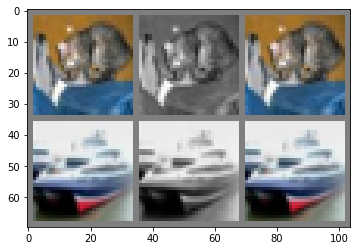

In [10]:
result_display_flag = 0
for j in range(2):
    # get some randoLm training images
    images_color = image_cpu_color[j]
#     print(images_color.shape)
    images_color = images_color.reshape(1,3,32,32)
    images_color_show = images_color.reshape(1,3,32,32)

    images_gray = rgb2gray_batch(images_color)
#     print("images_gray: ", images_gray.shape)
    images_gray = images_gray.reshape(1,1,32,32)
    third_tensor = torch.cat((images_gray, images_gray, images_gray), 1)
#     print("third_tensor: ", third_tensor.shape)

    images_gray = images_gray.to(device)
    outputs = mlp_net(images_gray)
#     print("outputs: ", outputs.shape)

    outputs = outputs.reshape(1,3,32,32)
#     print("outputs: ", outputs.shape)

    outputs = outputs.to("cpu")
    result_display = torch.cat((images_color_show, third_tensor, outputs), 0)
    if result_display_flag == 0:
        print("0")
        result_display_flag = 1 
        final_result_display = result_display
        print(final_result_display.shape)  
    else:
        print("1")
        final_result_display = torch.cat((final_result_display, result_display), 0)
        print(final_result_display.shape)  

print(final_result_display.shape)        
imshow(torchvision.utils.make_grid(final_result_display.detach(), nrow=3))

torch.Size([1, 3, 32, 32])
images_gray:  torch.Size([1, 32, 32])
third_tensor:  torch.Size([1, 3, 32, 32])
outputs:  torch.Size([1, 3072])
outputs:  torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])
images_gray:  torch.Size([1, 32, 32])
third_tensor:  torch.Size([1, 3, 32, 32])
outputs:  torch.Size([1, 3072])
outputs:  torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])
images_gray:  torch.Size([1, 32, 32])
third_tensor:  torch.Size([1, 3, 32, 32])
outputs:  torch.Size([1, 3072])
outputs:  torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])
images_gray:  torch.Size([1, 32, 32])
third_tensor:  torch.Size([1, 3, 32, 32])
outputs:  torch.Size([1, 3072])
outputs:  torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images_gray:  torch.Size([1, 32, 32])
third_tensor:  torch.Size([1, 3, 32, 32])
outputs:  torch.Size([1, 3072])
outputs:  torch.Size([1, 3, 32, 32])


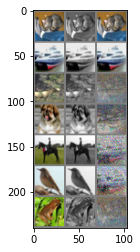

In [11]:
for i in range(5):
    # get some random training images
    images_color, images_label = next(iter(inference_trainloader_color))
    images_color_show = images_color.reshape(inference_batchSize,3,32,32)
    print(images_color.shape)
    images_gray = rgb2gray_batch(images_color)
    print("images_gray: ", images_gray.shape)
    images_gray = images_gray.reshape(inference_batchSize,1,32,32)
    third_tensor = torch.cat((images_gray, images_gray, images_gray), 1)
    print("third_tensor: ", third_tensor.shape)

    images_gray = images_gray.to(device)
    outputs = mlp_net(images_gray)
    print("outputs: ", outputs.shape)

    outputs = outputs.reshape(inference_batchSize,3,32,32)
    print("outputs: ", outputs.shape)

    outputs = outputs.to("cpu")
    new_result_display = torch.cat((images_color_show, third_tensor, outputs), 0)
    final_result_display = torch.cat((final_result_display, new_result_display), 0)
    
imshow(torchvision.utils.make_grid(final_result_display.detach(), nrow=3))

### Save the model

In [12]:
if not os.path.exists('./saved_model'):
    os.makedirs('./saved_model')

    
torch.save(mlp_net.state_dict(), model_path)

In [13]:
a = torch.tensor(((1,2),(3,4)))

In [14]:
print(a)

print(a.shape)

tensor([[1, 2],
        [3, 4]])
torch.Size([2, 2])


In [15]:
b = a[0]
print(b)

tensor([1, 2])
